# 1. Data wrangling and pipelines

> download the data, run the viral genome assembly pipelines and sanity check the assemblies

***

## Overview

* download the data
    - viral reference genomes from RefSeq
    - 3 Ebola virus (EBOV) MinIon run data
        - multiplexed on one flowcell
        - already basecalled with Guppy (both fast and high accuracy)
    - Nipah virus (NiV) MinIon run data

* assemble the samples using the de novo pipeline
    - demux and trim the basecalled reads
    - assemble (miniasm / redbean)
    - correct the assemblies (racon x4 iterations)
    - polish, either:
        - without signal (medaka)
        - with signal (nanopolish)
        - with signal and without (nanopolish then medaka)
        - without and with (medaka then nanopolish)

* assemble the samples using the reference guided pipeline

* assess the assemblies
    - quick assessment of all the assemblies against the current viral genomes in RefSeq
    - **note**: I've restricted this to just ebola for now, but can make this more generic later

***

**TODO**

1. add in reference guided pipeline
2. add in subsampling variations

***


## Download the data

Download the complete ebola assemblies from RefSeq:

In [1]:
!ncbi-genome-download --format fasta --assembly-level complete --fuzzy-genus --genus ebola viral -o tmp --parallel 8 --retries 2

Download the Ebola virus Nanopore run data from the [artic data releases](http://artic.network/protocol_validation_2019.html):

* we are using the Ebola virus (EBOV) minion run that sequenced 3 strains of the virus (Mayinga, Kikwit, Makona) using the metagenomic protocol and rapid PCR kit

In [1]:
!wget http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz --directory-prefix=tmp/
!tar -xvf tmp/EBOV_Metagenomics.tar.gz -C tmp/ --strip-components=1

--2019-10-08 14:36:27--  http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz
Resolving artic.s3.climb.ac.uk (artic.s3.climb.ac.uk)... 137.205.52.6
Connecting to artic.s3.climb.ac.uk (artic.s3.climb.ac.uk)|137.205.52.6|:80... connected.
HTTP request sent, awaiting response... 
  HTTP/1.1 200 OK
  Server: nginx/1.14.0
  Date: Tue, 08 Oct 2019 13:36:28 GMT
  Content-Type: application/gzip
  Content-Length: 1070346070
  Connection: keep-alive
  Accept-Ranges: bytes
  Last-Modified: Tue, 03 Sep 2019 15:29:47 GMT
  ETag: "6e2449545dc6d1ac030505b880132e29-8"
  x-amz-meta-s3cmd-attrs: atime:1567522299/ctime:1567522360/gid:1000/gname:artic/md5:eb30cd588722793c39455ceb97898874/mode:33188/mtime:1567522310/uid:1000/uname:artic
  x-amz-request-id: tx000000000000000017d35-005d9c90db-358ae6ba-s3-warwick
Length: 1070346070 (1021M) [application/gzip]
Saving to: ‘tmp/EBOV_Metagenomics.tar.gz’

EBOV_Metagenomics.t 100%[===================>]   1021M  2.51MB/s    in 7m 44s  

2019-10-08 14:44:

## De novo assembly pipeline

The library that we just downloaded contains 3 barcoded samples - we want barcodes 9, 10 and 11 (9=Mayinga,10=Kikwit,11=Makona)

This library was already basecalled with Guppy, both using the fast and high accuracy (hac) models. These are already in the current repository:

```
./pipelines/data/ebov-metagenomics-reads
```

First, run the de-novo assembly pipeline using the fast basecalled data.

* this will demux, trim, assemble, correct and polish the 3 samples
* **note**: this takes around 20 minutes using the settings below
* **note**: make sure you have docker installed and the daemon is running!

In [1]:
!nextflow run pipelines/long-read-assembly-dn.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcodes 09,10,11 \
    --output pipelines/data/ebov-dn-assemblies/r941_min_fast \
    --assembler miniasm \
    --subSamplingDepth 100 \
    --label fast

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly-dn.nf` [furious_kirch] - revision: 79fbe4b15a
-------------------------------------------------------
de novo long read assembly pipeline v0.1
-------------------------------------------------------
fastq dir      : /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast
fast5 dir      : /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Barcodes       : 09,10,11
Sequencing kit : Auto
Sampling depth : 100
Racon iterat.  : 4
Medaka model   : r941_min_fast
Output dir     : pipelines/data/ebov-dn-assemblies
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signal-check
Script dir     : /Users/willrowe/Desktop/signal-check/pipelines
-------------------------------------------------------
[-        ] process 


executor >  local (12)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[2e/4039aa] process > nanopolishIndexing (1)         [100%] 1 of 1
[ac/943b79] process > polishingWithMedaka (1)        [  0%] 0 of 1
[-        ] process > repolishingWithNanopolish      -
[-        ] process > polishingWithNanopolish        -
[-        ] process > repolishingWithMedaka          -
[-        ] process > assessAssemblies               -

executor >  local (13)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[ab/ccee82] process > nanopolishIndexing (2)  


executor >  local (24)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[49/8b6a99] process > nanopolishIndexing (3)         [100%] 3 of 3 ✔
[d7/2ae4ea] process > polishingWithMedaka (3)        [100%] 3 of 3 ✔
[5f/e0a2f9] process > repolishingWithNanopolish (3)  [100%] 3 of 3 ✔
[46/d2100d] process > polishingWithNanopolish (3)    [100%] 3 of 3 ✔
[ab/2dbc80] process > repolishingWithMedaka (2)      [ 50%] 1 of 2
[-        ] process > assessAssemblies               -

executor >  local (25)
[7e/7f0082] process > demuxingReads                  [100%] 1 of 1 ✔
[bb/1e0a6b] process > assemblingReads (1)            [100%] 3 of 3 ✔
[a0/8ac799] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[11/438d69] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[4

Run the pipeline again, this time using the high accuracy basecalled data:

* **note**: we change the medaka model and the label

In [6]:
!nextflow run pipelines/long-read-assembly-dn.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-hac \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcodes 09,10,11 \
    --output pipelines/data/ebov-dn-assemblies/r941_min_hac \
    --assembler miniasm \
    --subSamplingDepth 100 \
    --medakaModel r941_min_hac \
    --label hac

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly-dn.nf` [reverent_stone] - revision: 62bd3907b8
-------------------------------------------------------
de novo long read assembly pipeline v0.1
-------------------------------------------------------
fastq dir      : /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-hac
fast5 dir      : /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Barcodes       : 09,10,11
Sequencing kit : Auto
Sampling depth : 100
Racon iterat.  : 4
Medaka model   : r941_min_fast
Output dir     : pipelines/data/ebov-dn-assemblies/r941_min_hac
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signal-check
Script dir     : /Users/willrowe/Desktop/signal-check/pipelines
-------------------------------------------------------
executo


executor >  local (13)
[9c/cad299] process > demuxingReads                  [100%] 1 of 1 ✔
[30/fcadc1] process > assemblingReads (1)            [100%] 3 of 3 ✔
[0b/a6e132] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[d4/33e586] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[38/4a26bf] process > nanopolishIndexing (2)         [ 50%] 1 of 2
[b9/7080f5] process > polishingWithMedaka (1)        [100%] 1 of 1
[-        ] process > repolishingWithNanopolish      -
[-        ] process > polishingWithNanopolish        -
[-        ] process > repolishingWithMedaka          -
[-        ] process > assessAssemblies               -

executor >  local (14)
[9c/cad299] process > demuxingReads                  [100%] 1 of 1 ✔
[30/fcadc1] process > assemblingReads (1)            [100%] 3 of 3 ✔
[0b/a6e132] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[d4/33e586] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[38/4a26bf] process > nanopolishIndexing (2)  


executor >  local (25)
[9c/cad299] process > demuxingReads                  [100%] 1 of 1 ✔
[30/fcadc1] process > assemblingReads (1)            [100%] 3 of 3 ✔
[0b/a6e132] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[d4/33e586] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[ce/6a8d4a] process > nanopolishIndexing (3)         [100%] 3 of 3 ✔
[89/52f108] process > polishingWithMedaka (3)        [100%] 3 of 3 ✔
[1e/f6f74f] process > repolishingWithNanopolish (3)  [100%] 3 of 3 ✔
[91/079f5b] process > polishingWithNanopolish (3)    [100%] 3 of 3 ✔
[92/aec693] process > repolishingWithMedaka (3)      [ 67%] 2 of 3
[-        ] process > assessAssemblies               -

executor >  local (26)
[9c/cad299] process > demuxingReads                  [100%] 1 of 1 ✔
[30/fcadc1] process > assemblingReads (1)            [100%] 3 of 3 ✔
[0b/a6e132] process > correctingAssemblyWithRacon... [100%] 3 of 3 ✔
[d4/33e586] process > subsamplingReads (3)           [100%] 3 of 3 ✔
[c

## Reference-guided assembly pipeline

For each barcode and each basecalling model, we will run the reference-guided assembly pipeline.


## Quick assessment of the assemblies

As a sanity check, check the assemblies from each of the above pipelines against the viral RefSeq genomes:

In [2]:
# get a file list of all the viral genomes we downloaded
!find $PWD/tmp/refseq/viral/GCF_00*/*.gz > tmp/ref-genome-list.txt

# get a file list of all the assemblies we just made, for both fast and hac data
!find $PWD/pipelines/data/ebov-dn-assemblies/r941_min_*/*.assembly.racon.*.fasta > tmp/assembled-genomes.list

# run fastani to compute Average Nucleotide Identity
!fastani --ql tmp/assembled-genomes.list --rl tmp/ref-genome-list.txt -o tmp/fastani-out.tab --fragLen 100 --matrix

>>>>>>>>>>>>>>>>>>
Reference = [/Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000848505.1/GCF_000848505.1_ViralProj14703_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000854085.1/GCF_000854085.1_ViralProj15006_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000855585.1/GCF_000855585.1_ViralProj15012_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000888475.1/GCF_000888475.1_ViralProj51257_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000889155.1/GCF_000889155.1_ViralProj51245_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_003505815.1/GCF_003505815.1_ASM350581v1_genomic.fna.gz]
Query = [/Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/guppy-r941-fast-barcode-09.assembly.racon.medaka.fasta, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-dn-assemblies/r941_min_fast/guppy-r941-fast-barcode-09.assembl

In [3]:
# plot the pairwise ANI scores as a heatmap
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)

# convert triangular matrix to a regular one (https://github.com/marbl/Mash/issues/9#issuecomment-509837201)
def lower_triangle_to_full_matrix(filename):
    num_lines_in_file = sum(1 for line in open(filename))
    distances = []
    sample_names = []

    with open(filename) as f:
        next(f) # skip sample count line
        for line in f:
            elements = line.strip().split('\t')
            for i, e in enumerate(elements):
                if e == 'NA':
                    elements[i] = 0.0
            elements[0] = os.path.basename(elements[0])
            sample_names.append(elements[0])
            row = [float(e) for e in elements[1:]]
            row.extend([0.0] * (num_lines_in_file-1-len(row)))
            distances.append(row)
        np_array = np.asarray(distances)
        index_upper = np.triu_indices(num_lines_in_file-1)
        np_array[index_upper] = np_array.T[index_upper]
        return pd.DataFrame(np_array, columns=sample_names, index=sample_names)

df = lower_triangle_to_full_matrix('tmp/fastani-out.tab.matrix')

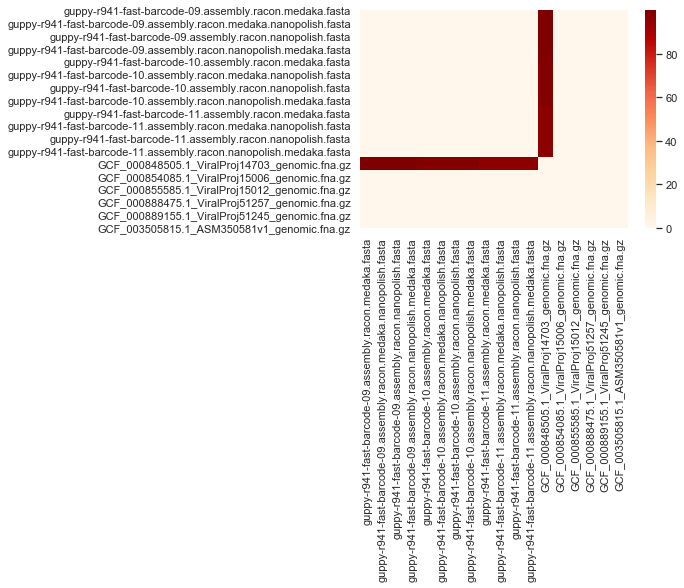

In [4]:
# make the plot for the fast basecalls
sns.heatmap(df, cmap="OrRd")

>for both fast and hac basecalling models, the closest reference genome (in RefSeq) to each assembly is `GCF_000848505.1_ViralProj14703_genomic.fna.gz` (which is Mayinga)

## Cleanup after running the pipeline

In [5]:
!rm -r work/
!rm -r .nextflow*